In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '337627',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 26)
page number = 20 (max: 100, len: 17)
page number = 30 (max: 100, len: 11)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (91657, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,337627,BGFreakDag2PT,N/A,On Radar
1,337627,Bstalf21,N/A,KS fall?
2,337627,bucklen_uk,N/A,I don't rate my own games (doesn't seem approp...
3,337627,carlcorey,N/A,"Turczi / Mindclash with O'Toole design, intere..."
4,337627,Dahanil,N/A,David Turczi + Ian O'Toole - tasty combination!
...,...,...,...,...
91652,167791,z_zadar,9,Some games are so much fun. Others can be a li...
91653,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
91654,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
91655,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15883 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         14867
9          14272
8          11938
N/A         6584
7           6460
           ...  
9.60975        1
6.681          1
8.17           1
8.12           1
6.95           1
Name: rating, Length: 520, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(69190, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6584, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Twilight Imperium is always a joy to play, until you realize you can't win. Deciding the winner of a 6 hour game on initiative order is just downright stupid. There are too many overly simple mechanisms in this game to merit its play length IMO. There's also a MASSIVE opportunity for kingmaking. Is it good design when the majority of players just straight up remove a part of the game? (support for the throne)  Anyway, it definitely scratches that 4x itch very well. "

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Totally don't understand the hype on this one.  It's a fine game, but I don't understand what wow factor it has.  Don't get me wrong, I would play it if someone asked, but I didn't see anything new or innovative about it."

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.43542534,  0.05541924, -0.03861873,  0.33252874,  0.03041599,
        -0.0903388 ,  0.05108023,  0.12498631, -0.51236284,  0.48238304,
        -0.06613763,  0.3817385 , -0.01009431, -0.05419247,  0.03728453,
         0.03116208, -0.20826414,  0.23696436,  0.20181282, -0.66726255,
         0.02363588, -0.2040986 ,  0.25106427,  0.1256224 ,  0.03082054,
         0.24718696, -0.88173664,  0.21733554,  0.02857121, -0.3444842 ,
        -0.2838907 ,  0.1338242 ,  0.01708944, -0.35131386,  0.05942433,
         0.10945774,  0.25329033, -0.25722507,  0.22151577, -0.79002357,
         0.11103141,  0.14340407, -0.03969017,  0.20914635, -0.11155718,
        -0.16889714, -0.2838904 , -0.2691303 ,  0.14834376,  0.10781826],
       [ 1.3167497 , -0.35126063, -0.26831505, -0.0789597 ,  0.34462166,
         0.0521491 , -0.721109  ,  0.11815029, -0.38752797,  0.07061311,
        -0.41714525, -0.06355918,  0.01112169,  0.10016744,  0.24356103,
 

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
102/102 - 8s - loss: 0.6428 - accuracy: 0.6323 - val_loss: 0.4844 - val_accuracy: 0.8526
Epoch 2/40
102/102 - 5s - loss: 0.4093 - accuracy: 0.8551 - val_loss: 0.3516 - val_accuracy: 0.8670
Epoch 3/40
102/102 - 5s - loss: 0.3076 - accuracy: 0.8784 - val_loss: 0.3105 - val_accuracy: 0.8788
Epoch 4/40
102/102 - 5s - loss: 0.2593 - accuracy: 0.8994 - val_loss: 0.3012 - val_accuracy: 0.8800
Epoch 5/40
102/102 - 5s - loss: 0.2275 - accuracy: 0.9118 - val_loss: 0.3028 - val_accuracy: 0.8786
Epoch 6/40
102/102 - 5s - loss: 0.2029 - accuracy: 0.9225 - val_loss: 0.3143 - val_accuracy: 0.8755
Epoch 7/40
102/102 - 5s - loss: 0.1837 - accuracy: 0.9309 - val_loss: 0.3271 - val_accuracy: 0.8728
Epoch 8/40
102/102 - 5s - loss: 0.1669 - accuracy: 0.9383 - val_loss: 0.3439 - val_accuracy: 0.8702
Epoch 9/40
102/102 - 5s - loss: 0.1531 - accuracy: 0.9438 - val_loss: 0.3623 - val_accuracy: 0.8660


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

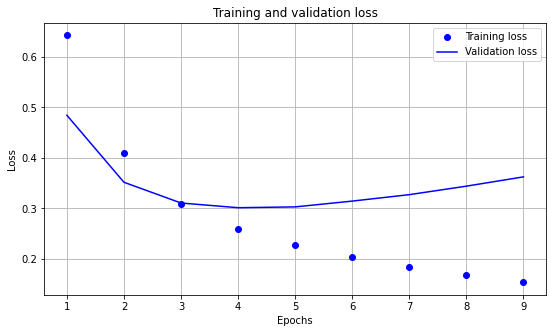

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

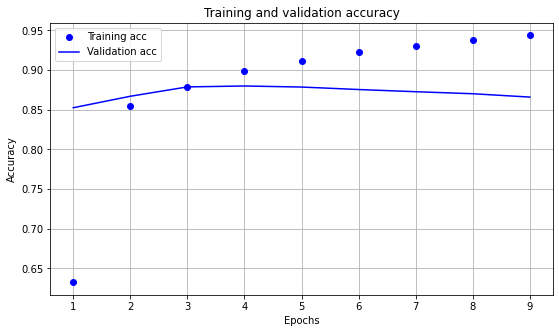

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Fun little push your luck game with enough variability in it to keep it interesting. This should be a hit for a long time."
score: 0.968498
actual value:1

input:
"1-4 player Co-op Legacy campaign  Character/Deck management "
score: 0.970952
actual value:1

input:
"1–2+ Players, 60-120 Min Purchased: July '18, Gamestop, $20"
score: 0.999705
actual value:1

input:
"Update: Drafting and adding corporations to the mix significantly improved this game. It's now a solid 10 in my book, and the components do not even matter.  Great game, but man those components are horrible. Overpriced for what you get in the box. However, it is so good that I cannot rate it under 9!"
score: 0.999324
actual value:1

input:
"Min. Player - 1 Max Player - 5 Best Player - 3"
score: 0.938351
actual value:1

input:
"1 a 5 jugadores - 1 hora y media"
score: 0.977303
actual value:1

input:
"Amazing Game which i never get tired of. The theme draws you in but the Game is simply excellent. Takes a Long Time but

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Christmas 2019 present from  [user=hauntedgamecafe]"
score: 0.902667

input:
"t18p98 reimplements Terra Mystica"
score: 0.989532

input:
"Looks like a lot to multi task and have fun"
score: 0.988608

input:
"With Kickstarter stretch goals and Medic."
score: 0.993149

input:
"Loved the third edition, so bought the fourth.  But this game goes onto the table perhaps once per year because of the time it takes to finish a game."
score: 0.961884

input:
"Punched out all of the pieces.  The insert is great.  Won't really have space to sleeve cards though -- though that's the thicker "not-penny" sleeves.  Penny sleeves may fit around the cards into the provided inserts."
score: 0.995839

input:
"Similar to Caylus in regard to expanding board which can be used by all players"
score: 0.906462

input:
"Widely praised 'where's waldo for adults'. Sounds like a potential couples activity (GM gift?)."
score: 0.369749

input:
"Zajimavy koncept, hraje se jen jednou. Jako "where is waldo"."
scor

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.35 |           3495 |
| 167355 |          8.41 |           1782 |
| 167791 |          8.21 |           8207 |
| 169427 |          8.60 |            214 |
| 169786 |          8.10 |           7319 |


In [46]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [47]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.73 |            309 |
| 167355 |          8.89 |            213 |
| 167791 |          8.89 |            437 |
| 169427 |          9.05 |             72 |
| 169786 |          8.65 |            588 |


In [48]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [49]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.020000,8.350000,1,2022
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.918131,8.769697,7.995975,2,2020
2,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.120527,8.554167,8.164073,3,2020
3,"<img src=""https://cf.geekdo-images.com/eUiju5S...","<a href=""https://boardgamegeek.com/boardgame/3...",8.583333,9.070000,8.757143,4,2021
4,"<img src=""https://cf.geekdo-images.com/-JD8JLn...","<a href=""https://boardgamegeek.com/boardgame/2...",8.391837,9.147619,8.740659,5,2021


In [50]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [51]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.020000,8.350000,1,2022
2,,Lost Ruins of Arnak,7.918131,8.769697,7.995975,2,2020
3,,Dune: Imperium,8.120527,8.554167,8.164073,3,2020
4,,Stationfall,8.583333,9.070000,8.757143,4,2021
5,,Merchants Cove,8.391837,9.147619,8.740659,5,2021


In [52]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.020000,8.350000,1,2022
2,,Chronicles of Drunagor: Age of Darkness,9.534483,8.454545,9.237500,18,2021
3,,Eclipse: Second Dawn for the Galaxy,8.744153,8.718072,8.739974,35,2020
4,,Brass: Birmingham,8.688725,8.801732,8.699192,26,2018
5,,Gloomhaven: Jaws of the Lion,8.624808,8.437879,8.606001,16,2020


In [53]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.534483,8.454545,9.237500,18,2021
2,,Stationfall,8.583333,9.070000,8.757143,4,2021
3,,Merchants Cove,8.391837,9.147619,8.740659,5,2021
4,,Eclipse: Second Dawn for the Galaxy,8.744153,8.718072,8.739974,35,2020
5,,Middara: Unintentional Malum – Act 1,8.601543,9.054167,8.715490,40,2019


In [54]:
# model.save('saved_model\my_model')

In [55]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [56]:
# some examples on "long" comments vs short comments

In [57]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"not interested much I DO NOT GET THE SET UP!  some evil is coming to destroy the island killing all cats, why should I be concerned with anything but nabbing cats? that said this seems like a game where if I could get over that I would enjoy it."
score: 0.963676

input:
"+ Legendary box, board extension, metal coins, custom dials, extra resource containers, wood tokens and custom deluxe resources."
score: 0.939318

input:
"2.1 - Might be some fast fun. Not my favourite subject matter or gameplay, but my oldest daughter quilts (she said she'd love to try this) and my son and daughter-in-law have cats. I think they'd all play this. Plus, reasonable price."
score: 0.998391

input:
"Got this to play solo, have yet to make it past the setup, the game is so daunting but I will keep trying until I'm able to play it. Love the theme and artwork, and the mechanics all make so much sense it's just so much to grock."
score: 0.999692

input:
"Seems to be very popular but does not appeal to 